# Text Frequency - Inverse Document Frequency

- $w_{tf}$: frecuencia de aparicion de una palabra en un documento
- $w_{df}$: frecuencia de aparicion en todos los documentos

$$ w_{tf - df} = w_{tf} \cdot \log{\frac{1}{w_{df}}} $$

In [166]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [167]:
# Get data
text_data = []
path= os.path.join('spam_data.csv')
with open(path) as file:
    reader= csv.reader(file)
    for row in reader:
        text_data.append(row)
    print("Data Loaded Sucessfully")

Data Loaded Sucessfully


In [168]:
# Split Reviews and Labels
[targets, reviews] = [list(x) for x in zip(*text_data)]

In [169]:
# PipeLine to performe Text Preprocessing
def text_preprocessing(text):
    # Utils
    lematizer = nltk.stem.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    # To Lower Case
    text= text.lower()
    # Remove punctuation marks and numbers
    text = re.findall(pattern= "[a-z]+", string= text)
    # Lemmatize
    text = [lematizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

In [170]:
# Process Labels
encoded_target = [1.0 if y == 'spam' else 0.0 for y in targets]

# Process Reviews
preprocessed_reviews = [text_preprocessing(review) for review in reviews]
preprocessed_reviews[:5]

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though']

In [171]:
def tokenizer(text):
    return nltk.word_tokenize(text)

tf_idf = TfidfVectorizer(tokenizer= tokenizer, max_features= 6000)
reviews_vect= tf_idf.fit_transform(preprocessed_reviews).toarray()

C:\Users\ADMIN\anaconda3\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [172]:
# SPlit data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(reviews_vect, encoded_target, train_size= 0.95)
# Testing Numpy Array to Tensor
X_test = tf.constant(x_test, dtype= tf.float32)
y_test = tf.constant(y_test, dtype= tf.float32)
# Training Numpy Array to Tensor
X_train = tf.constant(x_train, dtype= tf.float32)
y_train = tf.constant(y_train, dtype= tf.float32)
# Zip training reviews and targets to split them into batches
data_tensor = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [173]:
from typing import List

In [174]:
# Tensorflow Model
batch_size = 128

A = tf.Variable(tf.random.normal(shape= [reviews_vect.shape[1], 1], dtype= tf.float32))
b = tf.Variable(tf.random.normal(shape= [1, 1], dtype= tf.float32))

# Logistic Regression
@tf.function
def model(X) -> List[float]:
    return tf.nn.relu(tf.matmul(X, A) + b)
# Loss Funciont (Binary Cross-Entropy)
@tf.function
def loss_function(y_true, y_pred) -> float:
    return tf.reduce_mean(tf.losses.binary_crossentropy(y_true, y_pred))
# Optimizer
eta = 0.01
my_opt = tf.optimizers.Adam(learning_rate= eta)

# Get Accuracy
@tf.function
def score(X, y, threshold= 0.5):
    output = tf.cast(model(X) > threshold, dtype= tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(y, output), dtype= tf.float32))

# Main loop
loss_vect_train = []
loss_vect_test = []
accuracy_train = []
accuracy_test = []
iterations = 20
for ite in range(1, iterations+1):
    for x_rand, y_rand in data_tensor.batch(batch_size):
        with tf.GradientTape() as g:
            g.watch(A)
            g.watch(b)
            output = model(x_rand)
            loss = loss_function(y_rand, output)
        gradients = g.gradient(loss, [A,b])
        my_opt.apply_gradients(zip(gradients, [A,b]))
    # Predict (Train / Test)
    train_output = model(X_train)
    test_output = model(X_test)
    # Calculate Loss (Train / Test)
    train_loss = loss_function(y_train, train_output).numpy()
    test_loss = loss_function(y_test, test_output).numpy()
    # Calculate Accuracy (Train / Test)
    acc_train = score(X_train, y_train).numpy()
    acc_test = score(X_test, y_test).numpy()
    # Display Metrics
    print(f"Iteration:{ite} - Train Loss:{train_loss} - train_acc:{acc_train}", end= "")
    print(f"- Test Loss:{test_loss} - test_acc:{acc_test}")
    # Save Training Metrics
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
    loss_vect_train.append(train_loss)
    loss_vect_test.append(test_loss)

Iteration:1 - Train Loss:2.0481231212615967 - train_acc:0.8436792492866516- Test Loss:1.849323034286499 - test_acc:0.8537403345108032
Iteration:2 - Train Loss:2.0340898036956787 - train_acc:0.8501651287078857- Test Loss:1.7974512577056885 - test_acc:0.8700042366981506
Iteration:3 - Train Loss:2.0161075592041016 - train_acc:0.8544429540634155- Test Loss:1.814258098602295 - test_acc:0.8700042366981506
Iteration:4 - Train Loss:2.012138605117798 - train_acc:0.856099009513855- Test Loss:1.8177907466888428 - test_acc:0.8700042366981506
Iteration:5 - Train Loss:2.0081183910369873 - train_acc:0.8583067655563354- Test Loss:1.8168777227401733 - test_acc:0.8700042366981506
Iteration:6 - Train Loss:2.0071988105773926 - train_acc:0.8591349124908447- Test Loss:1.8165225982666016 - test_acc:0.8700042366981506
Iteration:7 - Train Loss:2.0065066814422607 - train_acc:0.8595489263534546- Test Loss:1.8165394067764282 - test_acc:0.8700042366981506
Iteration:8 - Train Loss:1.994218111038208 - train_acc:0.86

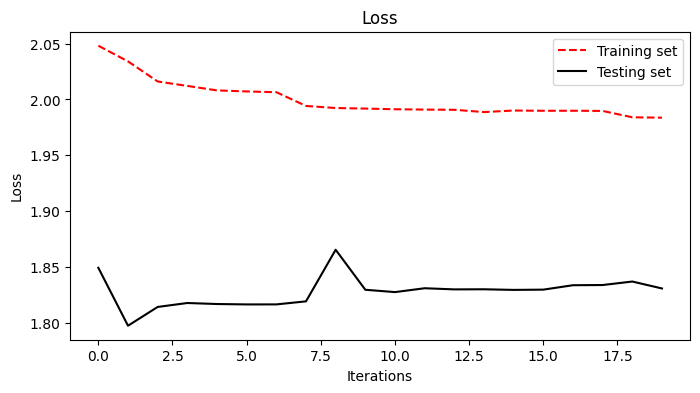

In [175]:
# Plot Loss
fig, ax = plt.subplots(nrows= 1, ncols= 1, figsize= (8,4))

ax.plot(loss_vect_train, '--r', label= 'Training set', )
ax.plot(loss_vect_test, '-k', label= 'Testing set')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

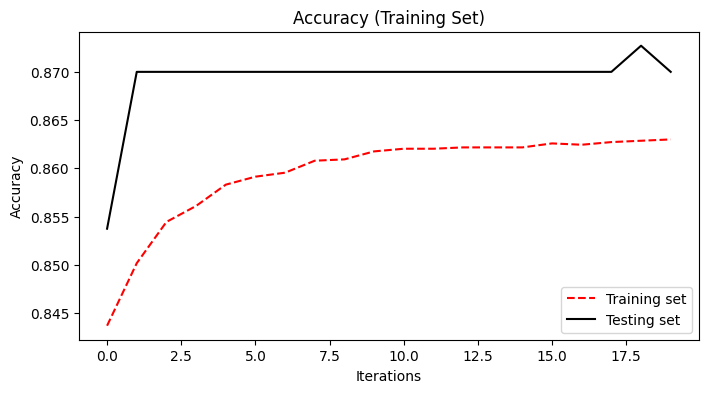

In [176]:
# PLot accuracy
fig, ax = plt.subplots(figsize= (8,4))

ax.plot(accuracy_train, '--r', label= 'Training set', )
ax.plot(accuracy_test, '-k', label= 'Testing set', )

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
ax.set_title('Accuracy (Training Set)')
plt.legend()
plt.show()

In [179]:
labels = np.array(['ham', 'spam'])
examples = ["I oversee training & development programs around our AI Accelerator Institute courses - are you interested in one of these?",
          "How it is going my friend, How are you?"]
preprocessed_exp = [text_preprocessing(example)  for example in examples]
vect_exp = tf_idf.transform(preprocessed_exp).toarray()
tensor_exp = tf.constant(vect_exp, dtype= tf.float32)
prediction = tf.cast(model(tensor_exp) > 0.5, dtype= tf.int32).numpy()
labels[prediction]

array([['ham'],
       ['ham']], dtype='<U4')